In [180]:
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from customer_behaviour.tools.dgm import DGM
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


def get_purchase_ratio(sequence):
    return np.count_nonzero(sequence)/len(sequence)

def get_purchase_amount(sequence):
    return np.sum(sequence)/np.count_nonzero(sequence)

def categorize_age(age):
    if age < 30: return 0
    elif 30 <= age < 40: return 1
    elif 40 <= age < 50: return 2
    elif 50 <= age < 60: return 3
    elif 60 <= age < 70: return 4
    elif 70 <= age: return 5

def categorize_amount(amount):
    if amount == 0: 
        return 0
    elif 0 < amount < 100: 
        return 1
    elif 100 <= amount < 200: 
        return 2
    elif 200 <= amount < 300: 
        return 3
    elif 300 <= amount < 400: 
        return 4
    elif 400 <= amount < 500: 
        return 5
    elif 500 <= amount < 600: 
        return 6
    elif 600 <= amount < 700: 
        return 7
    elif 700 <= amount < 800: 
        return 8
    elif 800 <= amount < 900: 
        return 9
    else:
        # Amount > 900
        return 10


dgm = DGM()

sample_length = 1000
n_experts = 1000


def generate_data(n_experts, sample_length):
    samples = []
    ratios = []
    indices = []
    amounts = []
    sex = []
    ages = []
    features = []
    for _ in range(n_experts):
        dgm.spawn_new_customer()
        sample = dgm.sample(sample_length)
        sample = np.sum(sample, axis=0)
        samples.append(sample)
        ratios.append(get_purchase_ratio(sample))
        amounts.append(get_purchase_amount(sample))
        sex.append(dgm.sex)
        ages.append(dgm.age)
    features.append(ratios)
    features.append(amounts)
    features.append(sex)
    features.append(ages)

    return samples, features

samples, features = generate_data(n_experts, sample_length)

#indices = [ls for ls in indices]


In [181]:
def cluster_data(features, n_clusters):
    features = np.array(features).T
    kmeans = KMeans(n_clusters=n_clusters).fit(features)
    print(kmeans.labels_)
    return kmeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
scaler = MinMaxScaler() 
scaler.fit(np.array(features).T)
cluster_features = scaler.transform(np.array(features).T)
#print(features)
n_clusters = 20
cluster_model = cluster_data(cluster_features.T, n_clusters)


[ 9  8  5  9  1  3 10 10 19  1 14  4  1  4 14  2  7 10  7  4  7  2  8  5
  7 13 14  8  3  8  4  5  7  0 16  7  0 10  2  8 16  4  8  7 12  2  9  2
 18 14 18  7 11  0  1 18  9 13 15  5 18 11 11  8 17  7 19  2 15  7  7 14
  8 19  5  5 18 11 11 10 16  6 17  7  5  4  7  8  3  1 17  9  3  5 10  2
 15  3 12 12 13  9 17  9  1  5 18 12 14  7 19 18 11  8  5  2  5  1 11  9
 17  2 17  8  8 11 10 15  9 10 15 15 18 19 19  6  7  8  2 15  7 16  1  6
  9  4 16  8 10 19 19  9  1  2  1 17 15 13 11  0 15 15  3  5  7  5 18  7
 19  5 17  2 17  8  0  7  7  5 10 17 16 18  9 19 16  8  4  4 12  0 19  2
  5  8  7  6 13  4 12 17  8 16 17 19  8 12 11 13 12  9  1  4 16  9  4 16
  5 10 12 12 11 19  6 14  4 15 13  8  0 14 13  0  0 16 13  6 18 16 12 16
 16 19  0 12  3 14 18  8  7 19  6 11 18 19  8  5  7 19  6 16 13  1 11  2
  5 18  9  7  3  5  3  9 17  6  2  0  5 13  1  1 14 11 12  1 18  8 12 11
  5 13  7 18  3 15  5 18  4  6  8 12 19 11 10  7 12 14  7  9 10 14 15 18
  2  1 10 11  8 10 19 12  3  8  0 12 11  3  5  0  6

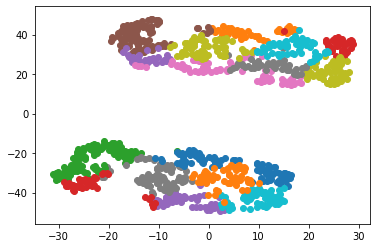

In [182]:
class Cluster():
    def __init__(self, samples, indices, features):
        self.data = []
        self.ratios = []
        self.amounts = []
        self.purchase_days = []
        self.feature1 = []
        self.feature2 = []
        for idx in indices:
            self.data.append(samples[idx])
            self.feature1.append(features[idx,0].tolist())
            self.feature2.append(features[idx,1].tolist())

        for sample in self.data:
            self.ratios.append(get_purchase_ratio(sample))
            self.amounts.append(get_purchase_amount(sample))
            self.purchase_days.extend(np.nonzero(sample)[0].tolist())
        sample_length = len(samples[0])
        self.freq_probs, self.bins = self.get_freqs_probs(self.ratios, sample_length)
        self.purchase_histo = self.get_purchase_probs(self.purchase_days, sample_length)
        
    def get_freqs_probs(self, ratios, sample_length):
        freq_probs, bins = np.histogram([ratio*sample_length for ratio in ratios], density=True, bins=20)
        bins = (bins[1:] + bins[:-1])/2
        freq_probs = freq_probs/np.sum(freq_probs)
        return freq_probs, bins

    def get_purchase_probs(self, indices, sample_length):
        histo = np.histogram(indices, density=False, bins=sample_length)
        #histo = plt.hist(indices, density=False, bins=sample_length)
        #plt.ylabel('Purchases')
        #plt.xlabel('Days')
        #plt.show()
        return histo[0]/len(indices)

from sklearn.manifold import TSNE
embedded_features = TSNE(n_components=2).fit_transform(cluster_features)
clusters = []
for label in range(n_clusters):
    #print([i for i, x in enumerate(cluster_model.labels_) if x == label])
    clusters.append(Cluster(samples, [i for i, x in enumerate(cluster_model.labels_) if x == label], embedded_features))

for cluster in clusters:
    plt.scatter(cluster.feature1, cluster.feature2)
plt.show()   


In [ ]:

    
freq_probs_hyper, hyper_bins = get_freqs_probs(hyper_ratio, sample_length)
freq_probs_normal, normal_bins = get_freqs_probs(normal_ratio, sample_length)
freq_probs_slow, slow_bins = get_freqs_probs(slow_ratio, sample_length)

histo_hyper = get_purchase_probs(hyper_idx, sample_length) # list of prob to buy a certain day during a year
histo_normal = get_purchase_probs(normal_idx, sample_length)
histo_slow = get_purchase_probs(slow_idx, sample_length)


In [183]:
def get_amount_probs(cluster, day):
    amounts = []
    n_experts = len(samples)

    for sample in cluster.data:
        if sample[day] > 0: amounts.append(sample[day])

    if not amounts:
        amounts.append(0)
    probs, bins = np.histogram(amounts, density=True)
    bins = (bins[1:] + bins[:-1])/2
    probs = probs/np.sum(probs)
    return probs, bins

def generate_purchase_days(label, clusters, sample_length, gen_length):
    cluster = clusters[label]
    cluster.label = label

    n_purchases = np.random.choice(cluster.bins, size=1, p=cluster.freq_probs)
    purchase_days = np.random.choice(range(sample_length), size=int(n_purchases), replace=False, p=cluster.purchase_histo)

    return sorted(purchase_days), cluster

def get_expert_label(samples, features, cluster_model, scaler):
    n_experts = len(samples)
    rand = random.randint(0, n_experts - 1)
    #print('rand')
    #print(rand)
    rand_exp = samples[rand]
    exp_sex = features[-2][rand]
    exp_age = features[-1][rand]
    init_seq = rand_exp[:100]
    data = []
    data.append(get_purchase_ratio(init_seq))
    data.append(get_purchase_amount(init_seq))
    data.append(exp_sex)
    data.append(exp_age)
    data = np.array(data).reshape(1, -1)
    data = scaler.transform(data)
    
    label = cluster_model.predict(data)[0]
    #print('true label')
    #print(label)
    return label, exp_sex, exp_age

def get_est_label(ts, scaler, sex, age):
    data = []
    data.append(get_purchase_ratio(ts))
    data.append(get_purchase_amount(ts))
    data.append(sex)
    data.append(age)
    data = np.array(data).reshape(1, -1)
    #scaler = RobustScaler() 
    data = scaler.transform(data)
    est_label = cluster_model.predict(data)[0]
    return est_label

def get_amounts(days, cluster):
    amounts = []
    for day in days:
        amount_probs, amount_bins = get_amount_probs(cluster, day)
        amounts.append(ceil(np.random.choice(amount_bins, size=1, p=amount_probs)[0]))

    return amounts

def run(samples, features, cluster_model, clusters, sample_length, gen_length, scaler):
    label, sex, age = get_expert_label(samples, features, cluster_model, scaler)
    purchase_days, cluster = generate_purchase_days(label, clusters, sample_length, gen_length)
    purchase_amounts = get_amounts(purchase_days, cluster)
    #print(purchase_amounts)
    ts = np.zeros((sample_length,))
    for (day, amount) in zip(purchase_days, purchase_amounts):
        ts[day] = amount
    est_label = get_est_label(ts, scaler, sex, age)
    
    #print('est label')
    #print(est_label)
    return est_label, label
    
import random 
n_runs = 1000
estimates = []
targets = []
gen_length = 1000
for i in range(n_runs):
    if i % 10 == 0:
        print(i)
    estimate, target = run(samples, features, cluster_model, clusters, sample_length, gen_length, scaler)
    estimates.append(estimate)
    targets.append(target)

error = 0
for (est, target) in zip(estimates, targets):
    if est != target: error+=1

classification_rate = (n_runs - error)/n_runs
print(classification_rate)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
0.943


In [ ]:
def get_eval_distr(ts, n=7):

    weeks = []
    for i, action in enumerate(ts):
        if action > 0 and i >=7:
            week = ts[i-n:i]
            week = [1 if day>0 else 0 for day in week]
            weeks.append(sorted(week))
    return weeks

def reduce_dimensionality(val_states, max_n_purchases, keep_only_unique=False):
    '''
    val_states: [[v_{0}], [v_{1}], ..., [v_{n-2}], [v_{n-1}]]
    max_n_purchases: The maximum number of purchases that is allowed in a validation state
    '''
    if not val_states: return []

    indices = np.argwhere(np.sum(val_states, axis=1) > max_n_purchases)  # list of lists
    indices = [x[0] for x in indices]

    n = len(val_states[0])
    substitute = n * [1]

    for i in indices:
        val_states[i] = substitute

    if keep_only_unique:
        temp = set(tuple(x) for x in val_states)
        return [list(x) for x in temp]
    else:
        return val_states

def get_counts(observed_val_states, possible_val_states, normalize=False):
    counts = len(possible_val_states) * [0]
    for temp in observed_val_states:
        i = possible_val_states.index(temp)
        counts[i] += 1
    if normalize:
        counts = list(np.array(counts) / np.sum(counts))
    return counts

def get_possible_val_states(n_last_days, max_n_purchases):
    possible_val_states = [list(x) for x in itertools.product([0, 1], repeat=n_last_days)]
    possible_val_states = reduce_dimensionality(possible_val_states, max_n_purchases, True)
    possible_val_states = sort_possible_val_states(possible_val_states)
    return possible_val_states

def get_wd(u, v, uv_normalized):
    if uv_normalized:
        wd = wasserstein_distance(u, v)
    else:
        uu = np.array(u)
        vv = np.array(v)
        wd = wasserstein_distance(uu / np.sum(uu), vv / np.sum(vv))
    return wd

purchase = get_eval_distr(ts)
purchase = reduce_dimensionality(purchase, max_n_purchases=7)
possible_val_states = get_possible_val_states(n_last_days=7, max_n_purchases=7)
counts_purchase_agent = get_counts(purchase, possible_val_states, normalize=True)

purchase = get_eval_distr(rand_exp)
purchase = reduce_dimensionality(purchase, max_n_purchases=7)
possible_val_states = get_possible_val_states(n_last_days=7, max_n_purchases=7)
counts_purchase_expert = get_counts(purchase, possible_val_states, normalize=True)

from scipy.stats import wasserstein_distance

dist = get_wd(counts_purchase_agent, counts_purchase_expert, True)
print(dist)




In [ ]:
mean = np.mean(ratios)
corona = mean + 0.02
vacation = mean - 0.02

hyper_idx = []
normal_idx = []
slow_idx = []
hyper_ratios = []
normal_ratios = []
slow_ratios = []

for sample, ratio in zip(samples, ratios):
    if ratio > corona: 
        hyper_idx.extend(np.nonzero(sample)[0].tolist())
        hyper_ratios.append(ratio)
    elif ratio < vacation: 
        slow_idx.extend(np.nonzero(sample)[0].tolist())
        slow_ratios.append(ratio)
    else: 
        normal_idx.extend(np.nonzero(sample)[0].tolist())
        normal_ratios.append(ratio)

print(len(hyper_ratios))
print(len(normal_ratios))
print(len(slow_ratios))